In [1]:
import math
import numpy as np
import numpy.linalg
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# %load distorter.py
# %load distorter.py
import math
from msilib.schema import Error
from multiprocessing.sharedctypes import Value
import numpy as np

class Distorter:
    """ Given a pixel's coordinates, calculate the distortion based on the
    height and width of the input image. """

    def __init__(self, width, height, conv_size):
        ''' Stores the height and width of the input image and the size of
        the convolution kernel.'''

        # try:
        if width <= 0 or height <= 0 or conv_size < 0:
            raise LessThanZeroException
        self.width = width
        self.height = height

        if conv_size > width or conv_size > height:
            raise TooBigKernelException

        self.kernel_size = conv_size
        self.R = self.relative_sampling_positions()


    def relative_sampling_positions(self):
        """ Computes the relative sampling positions as a matrix given the
        required size of the square convolution kernel. Assumes that the size
        of the kernel is odd so that there is a center. """

        try:
            if self.kernel_size % 2 == 0 or self.kernel_size < 1:
                raise ValueError()

            upper_lim = self.kernel_size // 2
            lower_lim = -1 * upper_lim

            return np.array([[(i, j) for j in range(lower_lim, upper_lim + 1)]
                             for i in range(lower_lim, upper_lim + 1)])
        except OddNumbersOnlyException:
            print("Invalid size: {self.kernel_size}. The size must be a positive odd number.")

    def lon_and_lat_2d(self, x, y):
        """ Returns the latitude and longitude of given coordinates. """
        lon = (x -(self.width / 2)) * ((2 * math.pi) / self.width)
        lat = (self.height*0.5 - y) * (math.pi / self.height)
        return lon, lat


    def lon_and_lat_3d(self, x, y, z):
        """ Backprojects, obtaining a latitude and longitude from the
        spherical domain. """
        lon = 0
        if x == 0:
            lon = math.pi / 4
        elif x >= 0:
            lon = math.atan(z / x)
        else:
            lon = math.atan(z / x) + math.pi

        if y < -1:
            lat = math.asin(max(-1, y))
        elif y > 1:
            lat = math.asin(min(1, y))
        else:
            lat = math.asin(y)
        return lon, lat

    def spherical_coords(self, lon, lat):
        """ Returns the spherical coordinates of a given latitude and
        longitude. """
        xu = math.cos(lat) * math.sin(lon)
        yu = math.sin(lat)
        zu = math.cos(lat) * math.cos(lon)

        return np.array([xu, yu, zu])

    def tangent_plane_vectors(self, spherical_coords):
        """ Computes the direction vectors that define a tangent plane to the
        given spherical point, tx and ty. spherical_coords is a numpy array. """
        spherical_coords = np.array(spherical_coords)
        tx = self.normalize(np.cross(np.array([0, 1, 0]), spherical_coords))
        ty = self.normalize(np.cross(spherical_coords, tx))
        return tx, ty

    def normalize(self, vector):
        """ Takes in a vector and converts it into a unit vector with the same
        direction. """
        norm=np.linalg.norm(vector, ord=2)
        if norm==0:
            norm=np.finfo(vector.dtype).eps
        return vector/norm


    def sampling_grid(self, tx, ty, spherical_coords):
        """ Computes the sampling grid on the tangent plane. """

        # Spatial resolution - distance between elements
        res = math.tan((2 * math.pi) / self.width)

        # Computes the sampling grid locations.
        sampling_grid_locations = np.empty(shape=(self.R.shape[0],
                                                  self.R.shape[1], 3))

        for i in range(0, self.R.shape[0]):
            for j in range(0, self.R.shape[1]):
                r = self.R[i][j]
                tx = np.array(tx)
                ty = np.array(ty)
                sampling_grid_locations[i, j] = spherical_coords + (res * (tx * r[0] + ty * r[1]))

        return sampling_grid_locations

    def backpropogate(self, sampling_grid_locations):
        """ Backpropogates point locations from the sampling grid to the
        equirectangular domain. """
        # Converts the sampling grid locations into a numpy array if it isn't already.
        if not isinstance(sampling_grid_locations, np.ndarray):
            sampling_grid_locations = np.array(sampling_grid_locations)

        # Array storing the new x, y sampling positions on the 2d plane.
        equirect = np.zeros(shape=(sampling_grid_locations.shape[0],
                                   sampling_grid_locations.shape[1], 2))
        for i in range(0, sampling_grid_locations.shape[0]):
            for j in range(0, sampling_grid_locations.shape[1]):
                point = sampling_grid_locations[i][j]
                lon, lat = self.lon_and_lat_3d(point[0], point[1], point[2])
                new_x = -((lon / (2 * math.pi)) + 0.25) * self.width
                new_y = (0.5 - (lat / math.pi)) * self.height
                equirect[i][j] = [new_x, new_y]

        return equirect

    def distort_point(self, x, y):
        """ Distorts the sampling locations on the equirectangular plane. """
        lon, lat = self.lon_and_lat_2d(x, y)
        sphere_coords = self.spherical_coords(lon, lat)
        tx, ty = self.tangent_plane_vectors(sphere_coords)
        sampling_grid = self.sampling_grid(tx, ty, sphere_coords)
        return self.backpropogate(sampling_grid)

    def distort_all_points(self):
        new_sampling_locations = np.zeros((self.height, self.width, self.kernel_size, self.kernel_size))

        # Computes the offsets for each row once.
        row_offsets = self.store_offsets()

        # Computes the offsets for each point in the image.
        for row in range(0, self.height):
            for col in range(0, self.width):
                new_sampling_locations[row][col] = row_offsets[row] + [col, row]
        return new_sampling_locations

    # Stores the offsets for each row. Width and height includes the padding for the image.
    def store_offset(self):
        row_offsets = []

        # Computes the kernel distortion for each row.
        for row in range(0, self.height):
            new_kernel = self.distort_point(0, row)
            row_offsets.append(new_kernel - [0, row])
        return row_offsets

class TooBigKernelException(Exception):
    pass

class LessThanZeroException(Exception):
    pass

class OddNumbersOnlyException(Exception):
    pass

In [3]:
distorter = Distorter(200, 200, 3)
print("\n___________________________________________________")
long, lat = distorter.lon_and_lat_2d(0, 0)
print(f"Test for latitude and longitude (0, 0): {long}, {lat}")
long2, lat2 = distorter.lon_and_lat_2d(200, 200)
print(f"Test for latitude and longitude (200, 200): {long2}, {lat2}")
long3, lat3 = distorter.lon_and_lat_2d(100, 100)
print(f"Test for latitude and longitude (100, 100): {long3}, {lat3}")

print("\n__________________________________________________")
sphere_coords = distorter.spherical_coords(long, lat)
print(f"Test for spherical coordinates ({long}, {lat}): {sphere_coords}")
sphere_coords2 = distorter.spherical_coords(long2, lat2)
print(f"Test for spherical coordinates ({long2}, {lat2}): {sphere_coords2}")
sphere_coords3 = distorter.spherical_coords(long3, lat3)
print(f"Test for spherical coordinates ({long3}, {lat3}): {sphere_coords3}")
    
print("\n__________________________________________________")
tx, ty = distorter.tangent_plane_vectors(sphere_coords)
print(f"Tangent plane vectors are {tx}, {ty}")
tx2, ty2 = distorter.tangent_plane_vectors(sphere_coords2)
print(f"Tangent plane vectors are {tx2}, {ty2}")
tx3, ty3 = distorter.tangent_plane_vectors(sphere_coords3)
print(f"Tangent plane vectors are {tx3}, {ty3}")

print("\n__________________________________________________")
sampling_grid = distorter.sampling_grid(tx, ty, sphere_coords)
print(f"Sampling grid vectors for tx and ty being {tx} and {ty}: \n {sampling_grid}\n")
sampling_grid2 = distorter.sampling_grid(tx2, ty2, sphere_coords2)
print(f"Sampling grid vectors for tx and ty being {tx2} and {ty2}: \n {sampling_grid2}\n")
sampling_grid3 = distorter.sampling_grid(tx3, ty3, sphere_coords3)
print(f"Sampling grid vectors for tx and ty being {tx3} and {ty3}: \n {sampling_grid3}\n")


print("\n__________________________________________________")
offsets = distorter.backpropogate(sampling_grid)
print(f"Offsets of elements to be sampled for (0, 0): \n {offsets} \n")
offsets2 = distorter.backpropogate(sampling_grid2)
print(f"Offsets of elements to be sampled for (200, 200): \n {offsets2} \n")
offsets3 = distorter.backpropogate(sampling_grid3)
print(f"Offsets of elements to be sampled for (100, 100): \n {offsets3} \n")


___________________________________________________
Test for latitude and longitude (0, 0): -3.1415926535897936, 1.5707963267948968
Test for latitude and longitude (200, 200): 3.1415926535897936, -1.5707963267948968
Test for latitude and longitude (100, 100): 0.0, 0.0

__________________________________________________
Test for spherical coordinates (-3.1415926535897936, 1.5707963267948968): [-5.17211691e-32  1.00000000e+00  1.60812265e-16]
Test for spherical coordinates (3.1415926535897936, -1.5707963267948968): [ 5.17211691e-32 -1.00000000e+00  1.60812265e-16]
Test for spherical coordinates (0.0, 0.0): [0. 0. 1.]

__________________________________________________
Tangent plane vectors are [ 1.0000000e+00 -0.0000000e+00  3.2162453e-16], [ 3.21624530e-16  1.60812265e-16 -1.00000000e+00]
Tangent plane vectors are [ 1.0000000e+00  0.0000000e+00 -3.2162453e-16], [3.21624530e-16 1.60812265e-16 1.00000000e+00]
Tangent plane vectors are [1. 0. 0.], [0. 1. 0.]

_____________________________

In [4]:
import matplotlib.pyplot as plt
from numpy import sin, cos, pi

def test_sampling_grid(w, h, conv_size, x, y, verbal=False):
    distorter = Distorter(w, h, conv_size)
    long, lat = distorter.lon_and_lat_2d(x, y)
    sphere_coords = distorter.spherical_coords(long, lat)
    tx, ty = distorter.tangent_plane_vectors(sphere_coords)
    sampling_grid = distorter.sampling_grid(tx, ty, sphere_coords)
    
    # Create a sphere
    r = 1
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
    x = r*sin(phi)*cos(theta)
    y = r*sin(phi)*sin(theta)
    z = r*cos(phi)

    #Set colours and render
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(
        x, y, z,  rstride=1, cstride=1, color='r', alpha=0.6, linewidth=0)

    ax.scatter(sphere_coords[0], sphere_coords[1], sphere_coords[2], color='b', marker='x')
    for i in range(0, sampling_grid.shape[0]):
        for j in range(0, sampling_grid.shape[1]):
            x, y, z = sampling_grid[i][j]
            ax.scatter(x, y, z, color='r', marker="o")
    if verbal: print(sampling_grid)

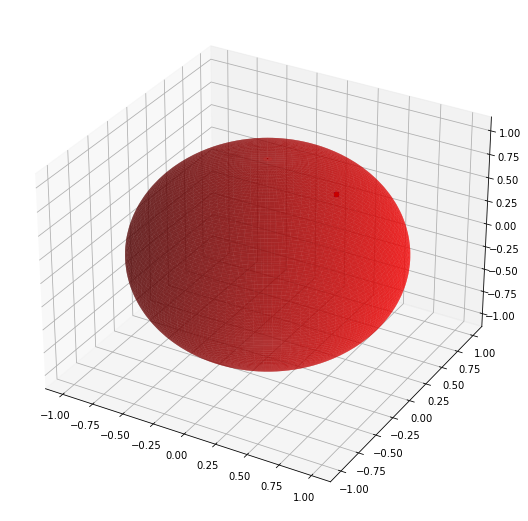

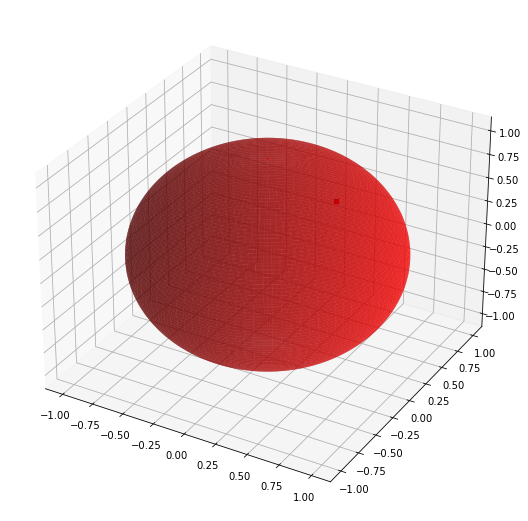

In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

grid = test_sampling_grid(40, 40, 1, 0, 0)
test_sampling_grid(40, 40, 1, 0, 1)


test_sampling_grid(100, 100, 3, 2, 20)

## Visualising the Distorted Sampling Positions

Below is a simple tool for showing how the kernel sampling positions for input size 200 x 200 are distorted as we vary the x and y coordinates.

In [6]:
HEIGHT = 25
WIDTH = 50

def demo(x, y, template_size):
    PADDING = template_size // 2
    distorter = Distorter(WIDTH, HEIGHT, template_size)
    grid = np.zeros(shape=(2*PADDING + HEIGHT, 2*PADDING + WIDTH))
    points = distorter.distort_point(x, y)
    
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if PADDING <= i < HEIGHT + PADDING:  
                grid[i][j] = 50
    
    for i in range(points.shape[0]):
        for j in range(points.shape[1]):
            points_x, points_y = points[i][j]
            grid[round(points_y) % HEIGHT][round(points_x)] = 256
          
    plt.imshow(grid, interpolation='nearest')

    print(points.shape)
    (points_rows, points_columns, _) = points.shape
    print(points[points_rows // 2][points_columns // 2])


In [7]:
interact(demo, x=widgets.IntSlider(max=WIDTH, min=0), y=widgets.IntSlider(max=HEIGHT, min=0), 
         template_size=widgets.IntSlider(min=1, max=min(WIDTH, HEIGHT), step=2))

interactive(children=(IntSlider(value=0, description='x', max=50), IntSlider(value=0, description='y', max=25)…

<function __main__.demo(x, y, template_size)>

## Storing the Offset for Each Row 

As specified in the paper and SphereNet, it is efficient to precompute the offset (difference between the distorted kernel and the normal convolution kernel locations) in an array. In fact, because the offset is constant for elements of the same row, we can store one offset array for each row. Refer to the method store_offset.

To test the storing the offset for each row, we will repeat what we did in "Visualising the Distorted Sampling Positions", but using the precomputed offsets. Again the image to be sampled from will be of width and height 50 x 50 but with the template size fixed at 3 x 3.

In [8]:
HEIGHT = 50
WIDTH = 50
TEMPLATE_SIZE = 15
PADDING = TEMPLATE_SIZE // 2
distorter = Distorter(WIDTH, HEIGHT, TEMPLATE_SIZE)
row_offsets = distorter.store_offset()

def offset_shape(y):
    grid = np.zeros(shape=(HEIGHT, WIDTH))
    points = row_offsets[y] + [HEIGHT//2, WIDTH//2]
    for i in range(points.shape[0]):
        for j in range(points.shape[1]):
            points_x, points_y = points[i][j]
            grid[round(points_y) % HEIGHT][round(points_x) % WIDTH] = 256
    plt.imshow(grid, interpolation="nearest")

def demo_with_stored_offsets(x, y):
    offset_shape(y)
    grid = np.zeros(shape=(2*PADDING + HEIGHT, 2*PADDING + WIDTH))
    points = row_offsets[y] + [x, y]
    # Colours the padding with a different colour.
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if PADDING <= i < HEIGHT + PADDING:  
                grid[i][j] = 50
    
    # Marks the new sampling positions computed using offsets and without.
    for i in range(points.shape[0]):
        for j in range(points.shape[1]):
            points_x, points_y = points[i][j]
            grid[round(points_y) % (HEIGHT)][round(points_x) % (WIDTH)] = 256
            

    plt.imshow(grid, interpolation='nearest')

    print(points.shape)
    (points_rows, points_columns, _) = points.shape
    print(points[points_rows // 2][points_columns // 2])

interact(demo_with_stored_offsets, x=widgets.IntSlider(max=WIDTH, min=0), y=widgets.IntSlider(max=HEIGHT, min=0), 
     template_size=widgets.IntSlider(min=1, max=min(WIDTH, HEIGHT), step=2))

interactive(children=(IntSlider(value=0, description='x', max=50), IntSlider(value=0, description='y', max=50)…

<function __main__.demo_with_stored_offsets(x, y)>

## Implementing the Convolution Operator

In [9]:
!pip install tensorflow

  Using cached tensorflow-2.8.0-cp38-cp38-win_amd64.whl (438.0 MB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
  Using cached rsa-4.8-py3-none-any.whl (39 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=773e75c525ed6270052e8fed3facdfa5ec0dce537b4a45c63dc69a55f69a7866
 

In [10]:
import tensorflow as tf